In [482]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
import matplotlib.animation as animation

logger = logging.getLogger(__name__)

In [483]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant

# # the following parameters are not being used in the sample code
PLATFORM_WIDTH = 0.25  # landing platform width
PLATFORM_HEIGHT = 0.  # landing platform height
w1 = [-PLATFORM_WIDTH, PLATFORM_WIDTH]
w2 = [0.1*-PLATFORM_WIDTH, 0.1*PLATFORM_WIDTH]
h = [PLATFORM_HEIGHT, PLATFORM_HEIGHT]
ROTATION_ACCEL = np.radians(20)  # rotation constant

In [484]:
# define system dynamics
# Notes:
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action: thrust or no thrust
        state[0] = y
        state[1] = y_dot
        """

        delta_state_ori = ROTATION_ACCEL* FRAME_TIME*t.tensor([0., 1, 0., 0., 0., 0.])

        sin = t.matmul(t.tensor([[0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [-1., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.]]),t.sin(t.transpose(state,0,1)))
        cos = t.matmul(t.tensor([[0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0., 0.],
                                 [1., 0., 0., 0., 0., 0.]]),t.cos(t.transpose(state,0,1)))
        cos_sin = cos+sin
        cos_sin = t.transpose(cos_sin,0,1)
        delta_state_pos = BOOST_ACCEL* FRAME_TIME*t.tensor([0., 0., 0., 1., 0., 1.])*cos_sin # x and y components of acceleration

        delta_state_combine = delta_state_ori + delta_state_pos

        action_mat = t.tensor([[0., 0.],
                         [2., 0.],
                         [0., 0.],
                         [0., 1.],
                         [0., 0.],
                         [0., 1.]])

        a_a = t.add(t.transpose(t.matmul(action_mat, t.transpose(action,0,1)),0,1) , t.tensor([0., -1., 0., 0., 0., 0.]))# get ori and pos accelerations

        delta_state = delta_state_combine*a_a

        state_gravity = GRAVITY_ACCEL * FRAME_TIME*t.tensor([0., 0., 0., 0., 0., -1.])
        state = state + delta_state + state_gravity

        step_mat = t.tensor([[1., FRAME_TIME, 0., 0., 0., 0.],
                             [0., 1., 0., 0., 0., 0.],
                             [0., 0., 1., FRAME_TIME, 0., 0.],
                             [0., 0., 0., 1., 0., 0.],
                             [0., 0., 0., 0., 1., FRAME_TIME,],
                             [0., 0., 0., 0., 0., 1.]])
        state = t.transpose(t.matmul(step_mat, t.transpose(state,0,1)),0,1)

        return state

In [485]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden1, dim_hidden2, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden1),
            nn.Tanh(),
            nn.Linear(dim_hidden1, dim_hidden2),
            nn.Tanh(),
            nn.Linear(dim_hidden2, dim_output),
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [486]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T, n):
        super(Simulation, self).__init__()
        self.T = T
        self.state = self.initialize_state(n)
        self.controller = controller
        self.dynamics = dynamics
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state,n):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state,n)

    @staticmethod
    def initialize_state(n):
        print('ini',n)
        initial = np.zeros((n,6))
        for i in range(n):
            initial[i] = [0.5*math.pi*(random.random()-0.5), 0.1*math.pi*(random.random()-0.5), # orientation state
                     (random.random()-0.5), 0.1*(random.random()-0.5), # horizontal state
                     0.5*random.random()+1, -0.1*random.random()]  # vertical state
        print('Generate %d initial states of rocket:' % n)
        print(initial)
        return t.tensor(initial, requires_grad=False).float()
    def error(self, state, n):
        states = t.square(state).sum(dim=0)*t.tensor([1., 1., 0.01, 1., 1., 1.]) # weight of each state
        return states.sum(dim=0)/n

In [487]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self,n):
        def closure():
            loss = self.simulation(self.simulation.state,n)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()

    def train(self, eps, max_epoch, n):
        conv_log = []
        conv_itr = []
        epoch = 0
        error = 100
        print('Start Training:')
        while error > eps and epoch <= max_epoch:
            loss = self.step(n)
            conv_log.append(loss.item())
            conv_itr.append(epoch)
            epoch += 1
            print('[%d] loss: %.5f' % (epoch, loss))
            error = loss.item()
        #     cord = self.visualize()
        # print('Landing Trajectory:')
        # for r in range(N):
        #     plt.quiver(cord[:,r, 2], cord[:,r, 4], -0.05*np.sin(cord[:,r, 0]), 0.05*np.cos(cord[:,r, 0]))
        #     plt.quiver(cord[-1,r, 2], cord[-1,r, 4], -0.05*np.sin(cord[-1,r, 0]), 0.05*np.cos(cord[-1,r, 0]),color='orange')
        #     plt.plot(w1, h, color="red", linewidth=3)
        #     plt.plot(w2, h, color="green", linewidth=3)
        #     plt.show()
        print('Convergence Plot:')
        plt.plot(conv_itr, conv_log)
        plt.yscale("log")
        plt.show()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        plt.scatter(data[:,0,2], data[:,0,4],s=5)
        plt.plot(w1, h, color="red", linewidth=3)
        plt.plot(w2, h, color="green", linewidth=3)
        plt.show()
        return data

In [488]:
class Evaluation:
    def __init__(self, simulation):
        self.simulation = simulation

    def test(self, n):
        print('Start Testing:')
        loss = self.simulation(self.simulation.state,n)
        print('loss: %.5f' % loss)
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        print('Landing Trajectory:')
        for r in range(n):
            plt.quiver(data[:,r, 2], data[:,r, 4], -0.05*np.sin(data[:,r, 0]), 0.05*np.cos(data[:,r, 0]))
            plt.quiver(data[-1,r, 2], data[-1,r, 4], -0.05*np.sin(data[-1,r, 0]), 0.05*np.cos(data[-1,r, 0]),color='orange')
            plt.plot(w1, h, color="red", linewidth=3)
            plt.plot(w2, h, color="green", linewidth=3)
            plt.show()
            end = data[-1,r,:]
            print(np.abs(end))

ini 100
Generate 100 initial states of rocket:
[[-1.43594900e-01 -1.18098521e-01  3.55324401e-02  4.63413248e-02
   1.28992948e+00 -9.97353854e-02]
 [ 6.14149979e-01  2.63068404e-03  9.51168901e-02  1.63707011e-02
   1.25630147e+00 -5.49522032e-02]
 [ 3.76784637e-01  3.37686136e-02  3.76077894e-01 -3.88514376e-02
   1.21953910e+00 -6.72820554e-02]
 [-3.09355031e-01 -1.82198378e-02  2.20610383e-01  3.25967644e-02
   1.19989557e+00 -4.22575018e-02]
 [ 3.64899191e-01  1.42109100e-01 -1.36592820e-01  2.59033273e-02
   1.06225291e+00 -9.81415912e-02]
 [-4.10140157e-01 -1.44453195e-03  8.00148725e-02 -3.97550900e-02
   1.22210659e+00 -4.23134605e-03]
 [-5.74081628e-01  1.18648170e-01  4.00109121e-01 -1.08624541e-02
   1.33499850e+00 -9.47456032e-02]
 [-6.88959210e-01  1.62670661e-02  3.33356059e-01  3.86847279e-03
   1.21826251e+00 -8.40435565e-02]
 [ 7.77341793e-01  1.08893148e-01 -4.65317368e-01 -1.38479457e-02
   1.06125909e+00 -8.43264841e-02]
 [-6.53379730e-01  6.41731127e-02 -1.8525472

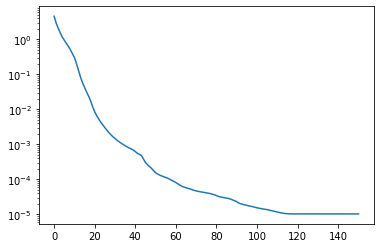

In [489]:
# Now it's time to run the code!

T = 100  # number of time steps
N = 100  # number of initial states
err = 0.001 # acceptable_error
itr = 150 # max_iteration
dim_input = 6  # state space dimensions
dim_hidden1 = 12  # latent dimensions
dim_hidden2 = 4  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden1, dim_hidden2, dim_output)  # define controller
s = Simulation(c, d, T, N)  # define simulation
o = Optimize(s)  # define optimizer
o.train(err**2,itr,N)  # solve the optimization problem

path = './Landing_Model.pth' # save model
t.save(c.state_dict(),path)

ini 10
Generate 10 initial states of rocket:
[[ 0.37419459 -0.11968632  0.08112005  0.00884988  1.22806682 -0.00296403]
 [ 0.56172406  0.05632367 -0.41214176  0.0068413   1.34687458 -0.05153673]
 [-0.53662647  0.13382647 -0.03005798 -0.02376325  1.07932549 -0.03044225]
 [ 0.29099782  0.14397694  0.28831503  0.00689342  1.20414802 -0.01368586]
 [-0.56526018 -0.07556028 -0.04700301 -0.01738216  1.36077664 -0.01208448]
 [-0.27016711 -0.00539173  0.11669398  0.02808859  1.36485486 -0.08755471]
 [ 0.20108494  0.07053808 -0.40773087  0.03314388  1.17314983 -0.0259729 ]
 [-0.31712946 -0.03996983  0.16958064 -0.02613717  1.43026149 -0.05531234]
 [ 0.40247594  0.04663445 -0.28863022 -0.01524063  1.01323601 -0.01905423]
 [-0.31574156  0.08086905 -0.33859908 -0.03587156  1.42885485 -0.03522093]]
Start Testing:
loss: 0.00001
Landing Trajectory:


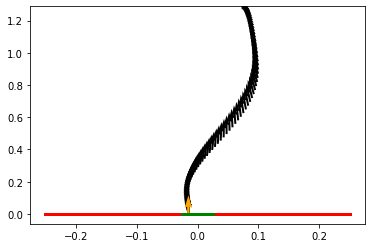

[0.00088431 0.00035759 0.0151153  0.00027822 0.00014086 0.00071864]


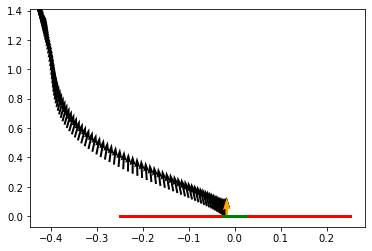

[0.0014011  0.00698614 0.01738806 0.00041236 0.00051872 0.00028125]


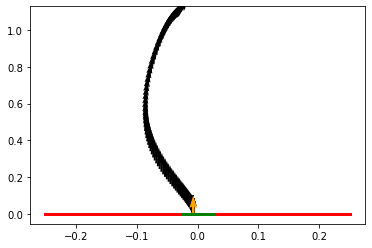

[5.0756446e-04 1.4351885e-05 7.1815690e-03 1.7361456e-04 2.6256926e-04
 1.7141737e-04]


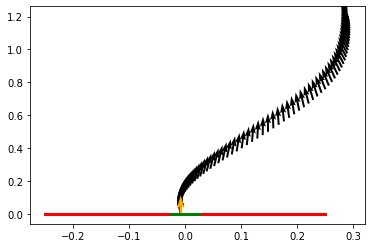

[0.00066085 0.00065981 0.00824038 0.00036005 0.00018594 0.00048212]


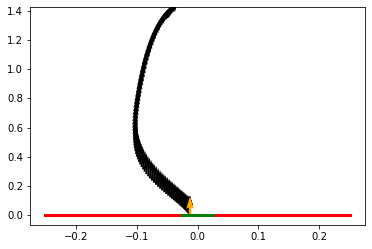

[0.00038014 0.00057328 0.01246337 0.00023059 0.00042006 0.00103182]


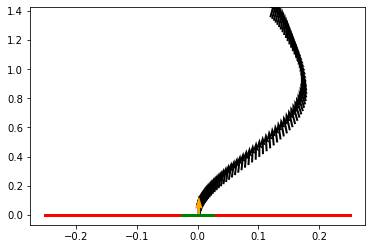

[7.2599953e-04 2.4388588e-04 2.1071045e-03 2.6679831e-04 2.4092600e-05
 4.2188354e-04]


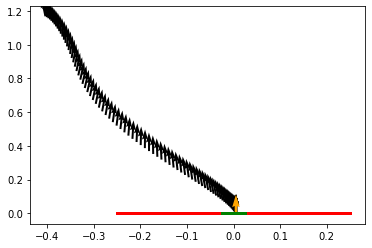

[3.8045100e-06 6.4262480e-04 5.2523222e-03 1.9971070e-04 2.4194381e-04
 2.1772273e-04]


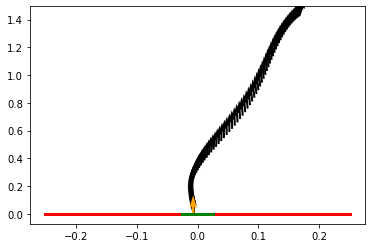

[6.4864953e-04 1.3621328e-03 7.2882408e-03 9.2284710e-05 1.9754285e-04
 1.1420269e-03]


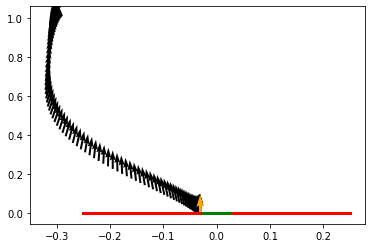

[0.00043208 0.00158069 0.03079963 0.00084641 0.00015008 0.00051   ]


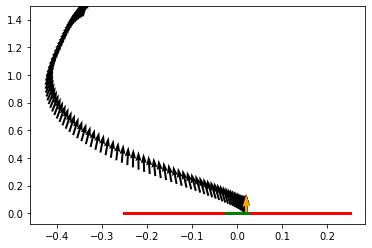

[6.9513940e-04 2.5815982e-03 2.0572050e-02 6.7557063e-04 6.7728281e-04
 4.4737943e-05]


In [490]:
# Test the control model by some new samples:

N_eval = 10 # number of initial states for testing
d_eval = Dynamics()  # define dynamics
model_eval =  Controller(dim_input, dim_hidden1, dim_hidden2, dim_output) # define controller

path = './Landing_Model.pth' # load model
model_eval.load_state_dict(t.load(path))
model_eval.eval()

s_eval = Simulation(model_eval, d_eval, T, N_eval )
eva = Evaluation(s_eval)  # initial evaluation simulator
eva.test(N_eval) # Test